### faster r-cnnによる車両のdetection
1. githubのレポジトリ(pytorch実装)（https://github.com/jwyang/faster-rcnn.pytorch )
2. githubのレポジトリ(keras実装)（https://github.com/jinfagang/keras_frcnn )
3. githubのレポジトリ(tensorflow実装)（https://github.com/endernewton/tf-faster-rcnn)
4. githubのレポジトリ(３のpytorch実装)(https://github.com/ruotianluo/pytorch-faster-rcnn )
5. githubのレポジトリ(pytorch実装)(https://github.com/longcw/faster_rcnn_pytorch )

いくつかレポジトリが存在するが、<br>
- pretrained modelが豊富
- roi_poolingやNMS部分のGPU依存無し(コンパイルの必要なし)
<br>などの理由により、https://github.com/ruotianluo/pytorch-faster-rcnn
を使用する

In [1]:
import pprint
import cv2
import numpy as np
import pandas as pd

import torch
import pytorch_faster_rcnn_master.tools._init_paths
from datasets.factory import get_imdb
from model.test import *
from model.config import cfg, cfg_from_file, cfg_from_list

from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1
from nets.mobilenet_v1 import mobilenetv1

# from pytorch_faster_rcnn_master.lib.nets.vgg16 import vgg16
# from pytorch_faster_rcnn_master.lib.nets.resnet_v1 import resnetv1
# from pytorch_faster_rcnn_master.lib.nets.mobilenet_v1 import mobilenetv1

import glob
from PIL import Image, ImageFont, ImageDraw
from matplotlib import pyplot as plt

%matplotlib inline

```
NET_FINAL=output/${NET}/${TRAIN_IMDB}/default/${NET}_faster_rcnn_iter_${ITERS}.pth
```

```
  CUDA_VISIBLE_DEVICES=${GPU_ID} time python ./tools/test_net.py \
    --imdb ${TEST_IMDB} \
    --model ${NET_FINAL} \
    --cfg experiments/cfgs/${NET}.yml \
    --net ${NET} \
    --set ANCHOR_SCALES ${ANCHORS} ANCHOR_RATIOS ${RATIOS} \
          ${EXTRA_ARGS}
```

In [2]:
def test_car_detection(net, imdb, weights_filename, img_paths, max_per_image=100, thresh=0):
    np.random.seed(cfg.RNG_SEED)
    """Test a Fast R-CNN network on an image database."""
    num_images = len(img_paths)
    # all detections are collected into:
    #  all_boxes[cls][image] = N x 5 array of detections in
    #  (x1, y1, x2, y2, score)
    all_boxes = [[[] for _ in range(num_images)]
                 for _ in range(imdb.num_classes)]

    output_dir = get_output_dir(imdb, weights_filename)
    
    for i in range(num_images):
        # timers
        _t = {'im_detect': Timer(), 'misc': Timer()}

        im = cv2.imread(img_paths[i])

        _t['im_detect'].tic()
        scores, boxes = im_detect(net, im)
        _t['im_detect'].toc()

        _t['misc'].tic()

        # skip j = 0, because it's the background class
        for j in range(1, imdb.num_classes):
            inds = np.where(scores[:, j] > thresh)[0]
            cls_scores = scores[inds, j]
            cls_boxes = boxes[inds, j * 4:(j + 1) * 4]
            cls_dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])) \
              .astype(np.float32, copy=False)
            keep = nms(
                torch.from_numpy(cls_boxes), torch.from_numpy(cls_scores),
                cfg.TEST.NMS).numpy() if cls_dets.size > 0 else []
            cls_dets = cls_dets[keep, :]
            all_boxes[j][i] = cls_dets

        # Limit to max_per_image detections *over all classes*
        if max_per_image > 0:
            image_scores = np.hstack(
                [all_boxes[j][i][:, -1] for j in range(1, imdb.num_classes)])
            if len(image_scores) > max_per_image:
                image_thresh = np.sort(image_scores)[-max_per_image]
                for j in range(1, imdb.num_classes):
                    keep = np.where(all_boxes[j][i][:, -1] >= image_thresh)[0]
                    all_boxes[j][i] = all_boxes[j][i][keep, :]
        _t['misc'].toc()

        print('im_detect: {:d}/{:d} {:.3f}s {:.3f}s' \
            .format(i + 1, num_images, _t['im_detect'].average_time(),
                _t['misc'].average_time()))

    return all_boxes

### network denifition

In [3]:
dataset = "COCO"
net_name = "res101"
# net_name = "vgg16"
cfg_name = "./pytorch_faster_rcnn_master/experiments/cfgs/{}.yml".format(net_name)

max_per_image = 100

In [4]:
# case ${DATASET} in
#   pascal_voc)
#     TRAIN_IMDB="voc_2007_trainval"
#     TEST_IMDB="voc_2007_test"
#     ITERS=70000
#     ANCHORS="[8,16,32]"
#     RATIOS="[0.5,1,2]"
#     ;;
#   pascal_voc_0712)
#     TRAIN_IMDB="voc_2007_trainval+voc_2012_trainval"
#     TEST_IMDB="voc_2007_test"
#     ITERS=110000
#     ANCHORS="[8,16,32]"
#     RATIOS="[0.5,1,2]"
#     ;;
#   coco)
#     TRAIN_IMDB="coco_2014_train+coco_2014_valminusminival"
#     TEST_IMDB="coco_2014_minival"
#     ITERS=490000
#     ANCHORS="[4,8,16,32]"
#     RATIOS="[0.5,1,2]"
#     ;;
#   *)
#     echo "No dataset given"
#     exit
#     ;;
# esac

if dataset == "voc":
    
    TRAIN_IMDB="voc_2007_trainval"
    TEST_IMDB="voc_2007_test"
    ITERS=70000
    ANCHOR_SCALES=[8,16,32]
    ANCHOR_RATIOS=[0.5,1,2]
    
elif dataset == "voc_0712":
    
    TRAIN_IMDB="voc_2007_trainval+voc_2012_trainval"
    TEST_IMDB="voc_2007_test"
    ITERS=110000
    ANCHOR_SCALES=[8,16,32]
    ANCHOR_RATIOS=[0.5,1,2]
    
elif dataset == "COCO":
    TRAIN_IMDB="coco_2014_train+coco_2014_valminusminival"
    TEST_IMDB="coco_2014_minival"
    ITERS=490000
    ANCHOR_SCALES=[4,8,16,32]
    ANCHOR_RATIOS=[0.5,1,2]

In [5]:
if net_name == 'vgg16':
    net = vgg16()
    model_path = "./pytorch_faster_rcnn_master/output/vgg16/coco_2014_train+coco_2014_valminusminival/coco_900k-1190k/vgg16_faster_rcnn_iter_1190000.pth"
elif net_name == 'res50':
    net = resnetv1(num_layers=50)
    model_path = "./pytorch_faster_rcnn_master/output/res50/coco_2014_train+coco_2014_valminusminival/coco_900k-1190k/res50_faster_rcnn_iter_1190000.pth"
elif net_name == 'res101':
    net = resnetv1(num_layers=101)
    model_path = "./pytorch_faster_rcnn_master/output/res101/coco_2014_train+coco_2014_valminusminival/coco_900k-1190k/res101_faster_rcnn_iter_1190000.pth"
elif net_name == 'res152':
    net = resnetv1(num_layers=152)
elif net_name == 'mobile':
    net = mobilenetv1()
else:
    raise NotImplementedError

In [6]:
cfg_from_file(cfg_name)

print('Using config:')
pprint.pprint(cfg)

Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'DATA_DIR': '/Users/matsumototakuya/Documents/each_project/pit_design/faster_rcnn/pytorch_faster_rcnn_master/data',
 'EXP_DIR': 'res101',
 'MATLAB': 'matlab',
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECAY': 4e-05},
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POOLING_MODE': 'align',
 'POOLING_SIZE': 7,
 'RESNET': {'FIXED_BLOCKS': 1, 'MAX_POOL': False},
 'RNG_SEED': 3,
 'ROOT_DIR': '/Users/matsumototakuya/Documents/each_project/pit_design/faster_rcnn/pytorch_faster_rcnn_master',
 'RPN_CHANNELS': 512,
 'TEST': {'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'MODE': 'nms',
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'gt',
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
          'RPN_TOP_N': 5000,
        

In [7]:
imdb_name = TEST_IMDB
imdb = get_imdb(imdb_name)

loading annotations into memory...
Done (t=0.83s)
creating index...
index created!


In [8]:
# load model
net.create_architecture(
    imdb.num_classes,
    tag='default',
    anchor_scales=ANCHOR_SCALES,
    anchor_ratios=ANCHOR_RATIOS)

net.eval()
if not torch.cuda.is_available():
    net._device = 'cpu'
net.to(net._device)

resnetv1(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2

In [9]:
net.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
print('Loaded.')

Loaded.


### detection

In [142]:
img_path = "../images/image_detail/0630_image_detail/2-1_all_corrected/62511/30110_20190630112017.jpg"
img_path = "../images/image_detail/0720_image_detail/2-1_all_corrected/115278/30014_20190720115707.jpg"
# img_path = '../images/image_detail/0722_image_detail/2-1_all_corrected/123490/30110_20190722161642.jpg'

In [157]:
bbox = test_car_detection(net, imdb, model_path, [img_path], max_per_image=max_per_image, thresh=0.4)

im_detect: 1/1 7.036s 0.003s


### visualize detection result

In [158]:
# Bounding-box colors
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in np.linspace(0, 1, len(imdb.classes[1:]))]

In [159]:
colors_to_int = []

for each_color in colors:
    colors_int = tuple([int(each_elem*255) for each_elem in each_color])
    colors_to_int.append(colors_int)

In [160]:
label_color_dict = {}
for each_class, each_color in zip(imdb.classes[1:], colors_to_int):
    label_color_dict[each_class] = each_color

In [161]:
target_classes = ['bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck']

In [162]:
def visualize_result(img_path, bbox, imdb, target_classes):

    img_ = Image.open(img_path)

    font = ImageFont.truetype(font='/System/Library/Fonts/ヒラギノ明朝 ProN.ttc',
                size=np.floor(3e-2 * img_.size[1] + 0.5).astype('int32'))
    thickness = (img_.size[0] + img_.size[1]) // 300

    cnt = -1

    for each_bbox, each_class in zip(bbox[1:], imdb.classes[1:]):

        cnt += 1

        if each_bbox[0].shape[0] == 0:
            continue
        predicted_class = each_class
        
        if predicted_class not in target_classes:
            continue
        
        for box_cnt in range(each_bbox[0].shape[0]):
            out_boxes = each_bbox[0][box_cnt, :4]
            out_scores = each_bbox[0][box_cnt, -1]
        #     print("class:{}, score:{}, bbox:{}".format(predicted_class, out_scores, out_boxes))

            left, top, right, bottom = out_boxes.tolist()
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(img_.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(img_.size[0], np.floor(right + 0.5).astype('int32'))

            label = '{} score:{:.2f}'.format(predicted_class, out_scores)

            draw = ImageDraw.Draw(img_)
            label_size = draw.textsize(label, font)

    #         print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=label_color_dict[predicted_class])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=label_color_dict[predicted_class])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw
        
    return img_

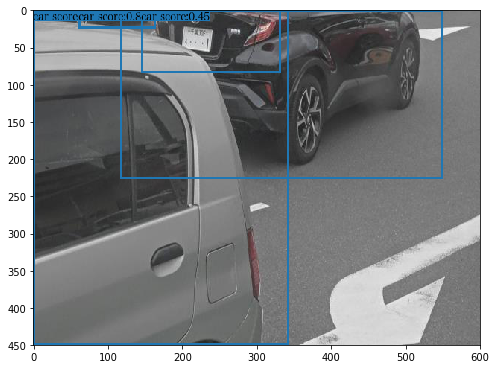

In [163]:
fig = plt.figure(figsize=(8,12))

plt.imshow(visualize_result(img_path, bbox, imdb, target_classes))

### detect and visualize various image

In [19]:
image_paths = glob.glob("../images/image_detail/0629_image_detail/2-1_all_corrected/*/*.jpg")

im_detect: 1/1 7.812s 0.003s
im_detect: 1/1 7.655s 0.003s
im_detect: 1/1 7.728s 0.003s
im_detect: 1/1 7.434s 0.003s
im_detect: 1/1 7.534s 0.004s
im_detect: 1/1 7.641s 0.003s


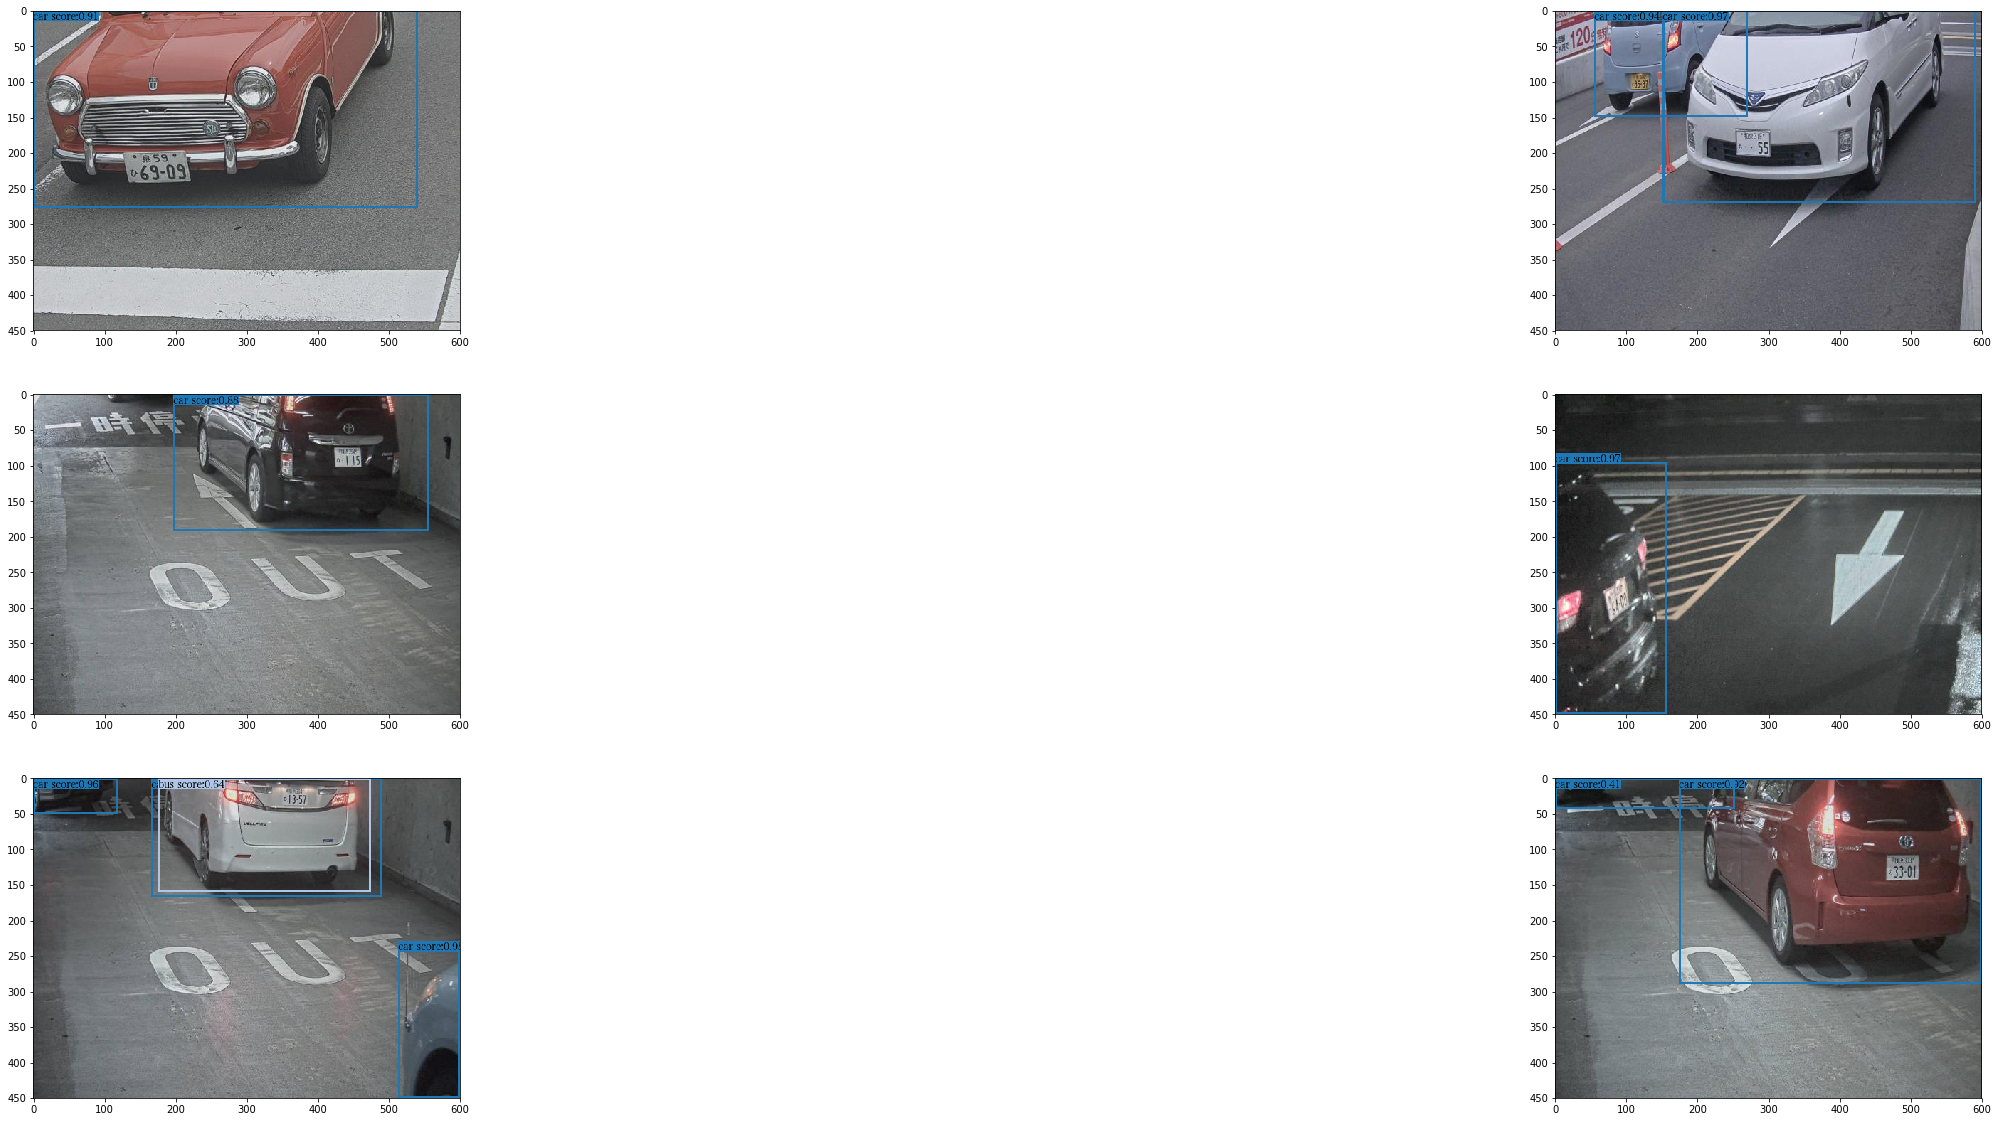

In [164]:
num_row = 3
num_col = 2
fig, ax = plt.subplots(num_row, num_col, figsize=(50,20))
# plt.subplots_adjust(wspace=0.5, hspace=0.5)

data_range = int(num_row*num_col)

cnt = 0

for each_img_path in image_paths[:data_range]:
    
    ax_ = ax[cnt//num_col][cnt%num_col]
    
    each_bbox = test_car_detection(net, imdb, model_path, [each_img_path], max_per_image=max_per_image, thresh=0.4)
    
    ax_.imshow(visualize_result(each_img_path, each_bbox, imdb, target_classes))
    cnt += 1

### detect and prepare detection result

In [165]:
import xml.etree.ElementTree as ET

In [166]:
#load xml
# annotationsのフォルダーにあるXMLファイル
xml_paths = glob.glob('../plate_labeling/annotations/*.xml')


# 以下の関数はmmdetectionから取っている。
# difficultを無視。
def parse_xml(xml_path):
    """XML形式のアノテーションデータを読み込む関数。
    
    Args:
        xml_path: XMLファイルへのパス。
        
    Returns:
        アノテーションのdict。
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    img_path = root.find('path').text
    img_path = img_path.replace("\\", "/")
    
    if "images-3" in img_path:
        img_path = img_path.replace("images-3/images-3", "images")
        img_path = img_path.replace("images-3", "images")
        
    img_path = img_path.replace("images-2", "images").replace("image_zip/images/", "")
        
    img_path = '../images' + img_path.split('images')[1]
    
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    bboxes = []
    labels = []
    bboxes_ignore = []
    labels_ignore = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        label = name
        difficult = int(obj.find('difficult').text)
        bnd_box = obj.find('bndbox')
        bbox = [
            int(bnd_box.find('xmin').text),
            int(bnd_box.find('ymin').text),
            int(bnd_box.find('xmax').text),
            int(bnd_box.find('ymax').text)
        ]
        bboxes.append(bbox)
        labels.append(label)
    if not bboxes:
        bboxes = np.zeros((0, 4))
        labels = np.zeros((0, ))
    else:
        bboxes = np.array(bboxes, ndmin=2) - 1
        labels = np.array(labels)
    if not bboxes_ignore:
        bboxes_ignore = np.zeros((0, 4))
        labels_ignore = np.zeros((0, ))
    else:
        bboxes_ignore = np.array(bboxes_ignore, ndmin=2) - 1
        labels_ignore = np.array(labels_ignore)
    annotation = {
        'filename': img_path,
        'width': w,
        'height': h,
        'ann': {
            'bboxes': bboxes.astype(np.float32),
            'labels': labels,
            'bboxes_ignore': bboxes_ignore.astype(np.float32),
            'labels_ignore': labels_ignore.astype(np.int64)
        }
    }
    return annotation


annotations = [parse_xml(xml_path) for xml_path in xml_paths]

print('データ数: {}枚'.format(len(annotations)), end='\n\n')

データ数: 4949枚



In [ ]:
pred_list = []
exclude_txt_1 = "true_image"
exclude_txt_2 = "false_image"

for each_annot in annotations:
    try:
        each_img_path = each_annot["filename"]

        if exclude_txt_1 in each_img_path:
            continue
        if exclude_txt_2 in each_img_path:
            continue
            
        idx_car = each_annot["ann"]["labels"].tolist().index("car")
        bbox_car_gt = each_annot["ann"]["bboxes"][idx_car]
        
        idx_plate = each_annot["ann"]["labels"].tolist().index("plate")
        bbox_plate_gt = each_annot["ann"]["bboxes"][idx_plate]

        bbox = test_car_detection(net, imdb, model_path, [each_img_path], max_per_image=max_per_image, thresh=0.3)

        for each_bbox, each_class in zip(bbox[1:], imdb.classes[1:]):

            if each_bbox[0].shape[0] == 0:
                continue
            if each_class not in target_classes:
                continue
                
            for box_cnt in range(each_bbox[0].shape[0]):
                out_boxes = each_bbox[0][box_cnt, :4]
                out_scores = each_bbox[0][box_cnt, -1]

#                 out_boxes = each_bbox[0][:,:4][0]
#                 out_scores = each_bbox[0][:,-1][0]
                x1, y1, x2, y2 = out_boxes.tolist()

                data_dict = {"img_path":each_img_path,
                            "class_name":each_class,
                            "x1":x1,
                            "y1":y1,
                            "x2":x2,
                            "y2":y2,
                            "score":out_scores,
                            "bbox_car_gt":bbox_car_gt,
                            "bbox_plate_gt":bbox_plate_gt}

            pred_list.append(data_dict)
    except Exception as e:
        print(e)
        continue

im_detect: 1/1 6.791s 0.003s
im_detect: 1/1 6.543s 0.005s
im_detect: 1/1 6.565s 0.003s
'NoneType' object has no attribute 'astype'
im_detect: 1/1 7.639s 0.003s
im_detect: 1/1 7.513s 0.004s
'NoneType' object has no attribute 'astype'
im_detect: 1/1 7.694s 0.003s
im_detect: 1/1 5.745s 0.003s
im_detect: 1/1 7.844s 0.003s
im_detect: 1/1 7.511s 0.003s
im_detect: 1/1 7.465s 0.005s
im_detect: 1/1 7.577s 0.004s
im_detect: 1/1 6.371s 0.003s
im_detect: 1/1 7.968s 0.003s
im_detect: 1/1 8.180s 0.003s
im_detect: 1/1 9.030s 0.004s
im_detect: 1/1 9.048s 0.004s
im_detect: 1/1 6.866s 0.004s
'car' is not in list
im_detect: 1/1 7.393s 0.003s
im_detect: 1/1 6.348s 0.003s
im_detect: 1/1 5.932s 0.004s
im_detect: 1/1 7.986s 0.003s
im_detect: 1/1 5.927s 0.003s
im_detect: 1/1 7.883s 0.003s
'car' is not in list
im_detect: 1/1 10.004s 0.005s
im_detect: 1/1 10.672s 0.004s
im_detect: 1/1 9.056s 0.005s
im_detect: 1/1 7.492s 0.003s
im_detect: 1/1 10.806s 0.006s
im_detect: 1/1 12.700s 0.003s
im_detect: 1/1 10.559s 0.

In [25]:
df_detect_result = pd.DataFrame(pred_list, columns=pred_list[0].keys())

In [28]:
df_detect_result.to_csv("./car_detect_result.csv",index=False, encoding="utf-8-sig")

### 保存済みの検知結果をもとに分析

In [60]:
df_car_detect_result = pd.read_csv("./car_detect_result.csv", encoding="utf-8-sig")

In [64]:
df_car_detect_result.head()

,x1,y2,x2,score,class_name,img_path,y1,bbox_plate_gt,bbox_car_gt
0,86.363632,311.079071,510.670105,0.938638,car,../images/image_detail/0703_image_detail/2-1_a...,0.0,"[286.0, 202.0, 374.0, 262.0]",[111. 0. 475. 303.]
1,0.000000,449.000000,537.648621,0.371086,car,../images/image_detail/0714_image_detail/2-1_a...,0.0,"[33.0, 234.0, 118.0, 309.0]",[ 0. 0. 482. 449.]
2,134.767792,355.812073,582.869751,0.742444,car,../images/image_detail/0728_image_detail/2-1_a...,0.0,"[347.0, 192.0, 445.0, 263.0]",[236. 94. 507. 287.]
3,261.824158,225.247574,552.897339,0.941204,car,../images/image_detail/0712_image_detail/2-1_a...,0.0,"[342.0, 142.0, 393.0, 177.0]",[296. 0. 526. 210.]
4,125.251770,386.464417,599.000000,0.981200,car,../images/image_detail/0706_image_detail/2-1_a...,0.0,"[407.0, 173.0, 479.0, 227.0]",[168. 1. 581. 358.]


In [62]:
# str型になっているpred resultを再度list化
def str_to_list_pred_result(pred_result):
    
    pred_list = []
    
    try:
        if pred_result == "[]":
            return pred_list

        #stringになっているpred resultをlist化
        pred_list =pred_result.replace("[", "").replace("]", "").split(".")

        pred_list = [float(s) for s in pred_list[:-1]]
    except Exception as e:
        print(pred_list)
        
    
    return pred_list

In [63]:
df_car_detect_result["bbox_plate_gt"] = df_car_detect_result["bbox_plate_gt"].apply(lambda x:str_to_list_pred_result(x))

In [65]:
df_car_detect_result["bbox_car_gt"] = df_car_detect_result["bbox_car_gt"].apply(lambda x:str_to_list_pred_result(x))

In [68]:
img_path_list = df_car_detect_result["img_path"].unique().tolist()
print(len(img_path_list))

3225


In [81]:
for each_img in img_path_list[3000:]:
    
    det_each_img = df_car_detect_result.groupby("img_path").get_group(each_img)
    
    img_ = Image.open(each_img)

    font = ImageFont.truetype(font='/System/Library/Fonts/ヒラギノ明朝 ProN.ttc',
                size=np.floor(3e-2 * img_.size[1] + 0.5).astype('int32'))
    thickness = (img_.size[0] + img_.size[1]) // 300
    
    for idx, row in det_each_img.iterrows():
        
        #draw predict bbox
        left, top, right, bottom = [row["x1"], row["y1"], row["x2"], row["y2"]]
        
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(img_.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(img_.size[0], np.floor(right + 0.5).astype('int32'))

        label = '{} score:{:.2f}'.format(row["class_name"], row["score"])

        draw = ImageDraw.Draw(img_)
        label_size = draw.textsize(label, font)

#         print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=label_color_dict[row["class_name"]])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=label_color_dict[row["class_name"]])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        
        
        left, top, right, bottom = row["bbox_car_gt"]
        
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(img_.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(img_.size[0], np.floor(right + 0.5).astype('int32'))
        
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=(255, 0, 0))
            
            
        left, top, right, bottom = row["bbox_plate_gt"]
        
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(img_.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(img_.size[0], np.floor(right + 0.5).astype('int32'))
        
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=(255, 255, 0))
        
        del draw
    break

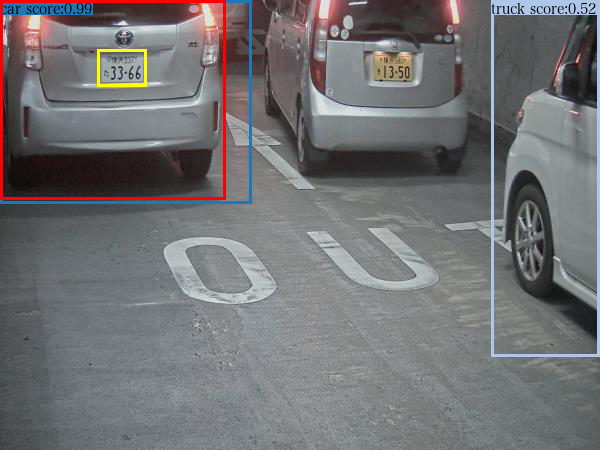

In [82]:
img_

In [83]:
each_img

'../images/image_detail/0722_image_detail/2-1_all_corrected/123490/30110_20190722161642.jpg'

In [84]:
det_each_img

,x1,y2,x2,score,class_name,img_path,y1,bbox_plate_gt,bbox_car_gt
4360,0.000000,202.560303,250.684448,0.987342,car,../images/image_detail/0722_image_detail/2-1_a...,0.0,"[97.0, 49.0, 146.0, 86.0]","[0.0, 0.0, 225.0, 199.0]"
4361,491.314606,355.645813,599.000000,0.515272,truck,../images/image_detail/0722_image_detail/2-1_a...,0.0,"[97.0, 49.0, 146.0, 86.0]","[0.0, 0.0, 225.0, 199.0]"
